In [1]:
import tensorflow as tf
import keras as K
import myutils 
%load_ext autoreload
%reload_ext autoreload
%autoreload 2 

allNews = myutils.initDF()

# tf.config.list_logical_devices(), tf.config.list_physical_devices()

Loading data from processed file


## Create balanced dataset and create train, validation and test sets

In [2]:
from sklearn.model_selection import train_test_split 
# Pop the label column
balancedLabels = allNews.pop('label')

# Split the data into train, test, and validation sets
x_train, x_test, y_train, y_test = train_test_split(allNews, balancedLabels, test_size=0.1, train_size=0.9, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2222, train_size=0.7778, shuffle=True)

## Create unbalanced dataset and create train, validation and test sets
### Only half fake news

In [3]:
# FakeNews label = 1
x_trainUF, y_trainUF = myutils.unbalance(x_train, y_train, 1)

### Only half real news

In [4]:
# RealNews label = 1
x_trainUR, y_trainUR = myutils.unbalance(x_train, y_train, 0)

## Dict Index

In [5]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vectorizer = Tokenizer(num_words=5000)

vectorizer.fit_on_texts(x_train.title)
vectorizer.fit_on_texts(x_train.text)
vectorizer.fit_on_texts(x_train.subject)

vocab_size = len(vectorizer.word_index) + 1

def text_to_sequence(text):
    res = np.array([vectorizer.word_index[word] for word in text.split() if word in vectorizer.word_index])
    return res.sum()
    
def sequence_to_text(sequence):
    return ' '.join([vectorizer.word_index[i] for i in sequence])

## Embedding

In [6]:
import numpy as np
embedding_dict = {}
with open("./embeddings/glove.6B.100d.txt") as f:
    for line in f:
        words, coefficients = line.split(maxsplit=1)
        coefficients = np.fromstring(coefficients, "f", sep=" ")
        embedding_dict[words] = coefficients

### Embedding Matrix

In [7]:
import numpy as np
embedding_dim = 100
vocab_size = len(vectorizer.word_index) + 2

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vectorizer.word_index.items():
    embedding_vector = vectorizer.word_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(126421, 100)

# Tensorflow embedding layer

In [8]:
embedding_layer = K.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer= K.initializers.Constant(embedding_matrix), trainable=False)

# Tensorflow CNN model

In [9]:
input = K.layers.Input(shape=(None, ), dtype='int64')
embedded_input = embedding_layer(input)
x = K.layers.Conv1D(128, 1, activation='selu')(embedded_input)
x = K.layers.MaxPooling1D(1)(x)
x = K.layers.Conv1D(128, 1, activation='selu')(x)
x = K.layers.MaxPooling1D(1)(x) 
x = K.layers.Conv1D(128, 1, activation='relu')(x)
x = K.layers.MaxPooling1D(1)(x) 
x = K.layers.Conv1D(128, 1, activation='relu')(x)
x = K.layers.GlobalMaxPooling1D()(x)
x = K.layers.Dense(128, activation='relu')(x)
x = K.layers.Dropout(0.5)(x)
predictions = K.layers.Dense(1, activation='sigmoid')(x)
model = K.models.Model(input, predictions)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         12642100  
                                                                 
 conv1d (Conv1D)             (None, None, 128)         12928     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         16512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 12

In [10]:
from keras_preprocessing.sequence import pad_sequences

def adapt(df, columns = ['title', 'text', 'subject']):
    for column in columns:
        df[column] = pad_sequences(vectorizer.texts_to_sequences(df[column]), maxlen=1000, padding='post').tolist()
    return df

x_train = adapt(x_train)
x_val = adapt(x_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

In [11]:
print(x_train.text.shape, x_val.text.shape, y_train.shape, y_val.shape)
print(x_train.text)

(31429,) (8979,) (31429,) (8979,)
11685    [1475, 70, 27, 368, 634, 45, 47, 2051, 9, 222,...
31157    [107, 70, 33, 8, 35, 71, 12, 367, 257, 2, 1, 2...
26712    [143, 128, 12, 364, 98, 3, 1, 413, 143, 128, 1...
29134    [62, 226, 1034, 38, 1, 2515, 3, 1, 356, 33, 8,...
25036    [1011, 2256, 70, 138, 1344, 9, 228, 564, 197, ...
                               ...                        
840      [107, 70, 1, 88, 78, 39, 23, 1315, 4, 147, 365...
23653    [1475, 70, 6, 1475, 359, 356, 261, 3, 4, 2974,...
25813    [70, 4, 133, 2874, 4, 1051, 85, 259, 197, 1808...
29806    [15, 8, 68, 913, 81, 215, 733, 71, 12, 1, 446,...
17866    [70, 1, 3159, 1926, 3384, 1095, 30, 4660, 2241...
Name: text, Length: 31429, dtype: object


In [12]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    min_delta=0.0005,
    restore_best_weights=True
)

model.compile(
    optimizer=K.optimizers.Adam(learning_rate=0.01),
    # optimizer=K.optimizers.Adam(learning_rate=0.001), 
    loss=K.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)
hist = model.fit(x_train.text, y_train, 
    batch_size=10, 
    epochs=20, 
    validation_data=(x_val.text, y_val), 
    # callbacks=[early_stopping]
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
tensor = x_train.text
print(f"Value of the tensor = \n {tensor}")
print(f"Number of dimensions = {len(tensor.shape)}")
print(f"Tensor's shape = {tensor.shape}")

Value of the tensor = 
 17334     10
18054     71
17165    109
3063      76
36388    741
        ... 
12864    557
14694     27
34440     26
22425    163
20694    554
Name: text, Length: 31429, dtype: int32
Number of dimensions = 1
Tensor's shape = (31429,)


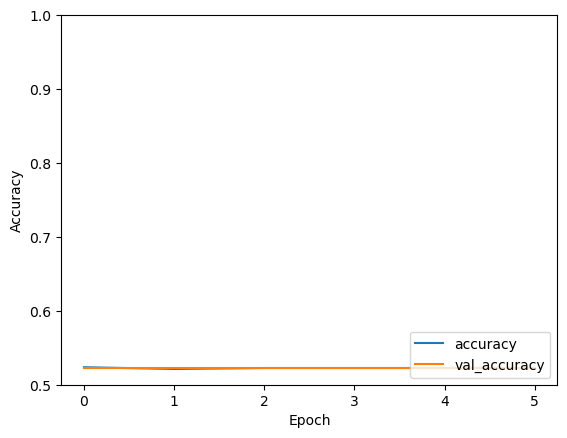

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')